In [1]:
import pandas as pd
import numpy as np
import cv2

In [2]:
data = pd.read_csv('./data.csv', encoding='utf8')

# Exploratory

In [3]:
data.describe()

,id,familyId,height,width
count,4909.000000,4909.000000,4909.000000,4909.000000
mean,5951.928702,11.709717,487.347118,381.796700
std,2226.224901,7.159314,237.314469,231.194613
min,0.000000,0.000000,208.000000,64.000000
25%,5117.000000,6.000000,306.000000,128.000000
50%,6344.000000,11.000000,445.000000,384.000000
75%,7571.000000,18.000000,639.000000,512.000000
max,9338.000000,24.000000,5334.000000,1024.000000


In [4]:
DIMENSION = 256
IMG_SIZE = (DIMENSION, DIMENSION)

def getImages(path):
  image = cv2.imread(path)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image, IMG_SIZE)
  return np.array(image, dtype='float32')

data['image'] = data['path'].apply(getImages)
data['image'].head()

0    [[[87.0, 87.0, 87.0], [50.0, 50.0, 50.0], [3.0...
1    [[[59.0, 59.0, 59.0], [50.0, 50.0, 50.0], [6.0...
2    [[[58.0, 58.0, 58.0], [50.0, 50.0, 50.0], [6.0...
3    [[[87.0, 87.0, 87.0], [50.0, 50.0, 50.0], [3.0...
4    [[[87.0, 87.0, 87.0], [50.0, 50.0, 50.0], [3.0...
Name: image, dtype: object

# Mostrando imagenes

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

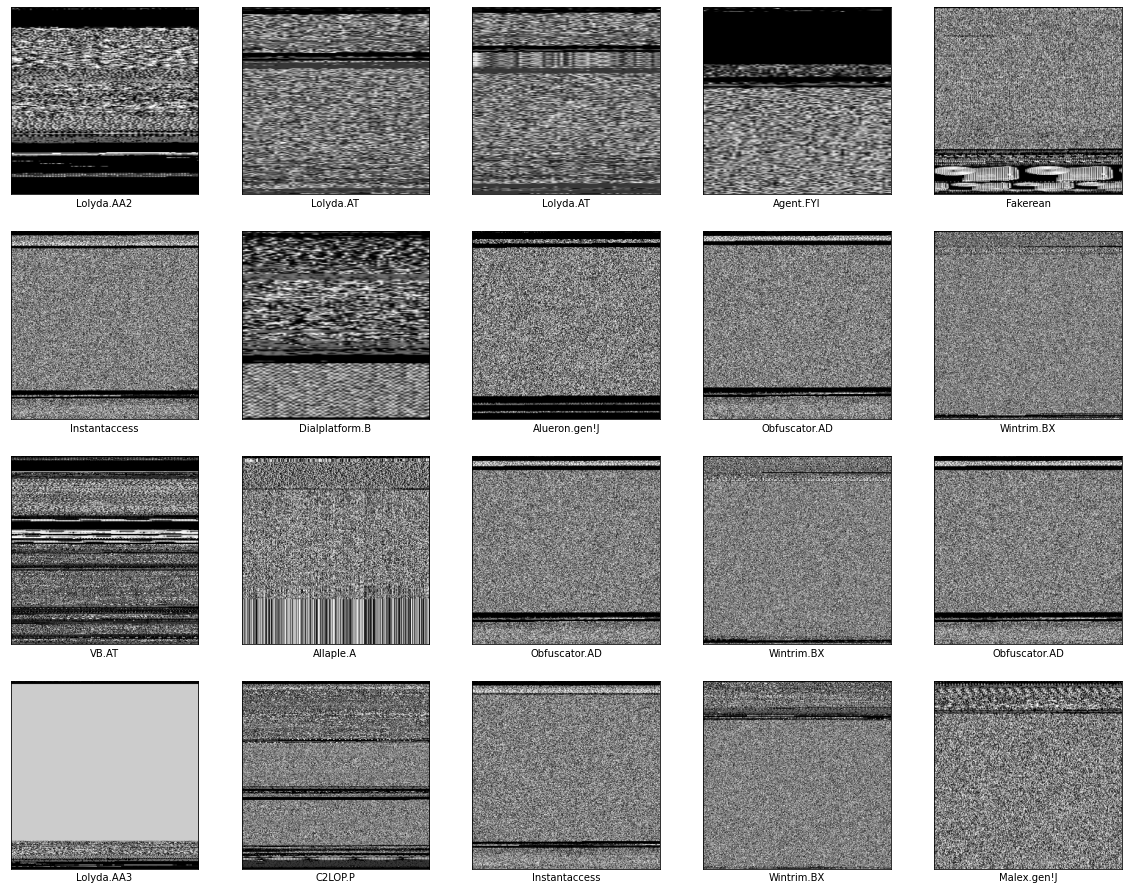

In [6]:
to_show = data.sample(20)

fig_size = (20, 20)
fig = plt.figure(figsize=fig_size)

id = 0
for index, row in to_show.iterrows():
  plt.subplot(5, 5, id + 1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)

  plt.imshow(row['image'].astype(np.uint8))
  plt.xlabel(row['familyName'])
  id += 1

plt.show()

# Manipulacion de la data

In [7]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [8]:
data.iloc[0]

id                                                            0
familyId                                                      0
familyName                                            Adialer.C
file                       000bde2e9a94ba41c0c111ffd80647c2.png
path          ./data/Adialer.C/000bde2e9a94ba41c0c111ffd8064...
height                                                      410
width                                                       512
image         [[[87.0, 87.0, 87.0], [50.0, 50.0, 50.0], [3.0...
Name: 0, dtype: object

In [9]:
total_classes = np.unique(data.familyName)
number_of_total_classes = len(total_classes)
number_of_total_classes

25

In [10]:
images = []

for index, row in data.iterrows():
    images.append(row["image"].astype(float))

images =  np.array(images)

In [11]:
len(images)

4909

In [12]:
x_train = images

In [13]:
y_train = data.iloc[:, 0].values.astype('int32')

In [14]:
y = np.zeros((len(data),25))
for index, row in data.iterrows():
  y[index][row['familyId']] = 1
print(len(y))

4909


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, '1.0')

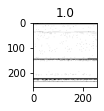

In [15]:
plt.subplot(331)
plt.imshow(x_train[1], cmap=plt.get_cmap('gray'))
plt.title(y[1][0])

In [16]:
print('Train:', x_train.shape, y.shape)

Train: (4909, 256, 256, 3) (4909, 25)


# Desarrollo del modelo

In [17]:
train, X_stealed, target, y_stealed = train_test_split(x_train, y, test_size=0.50, random_state=1)
X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=0.30, random_state=1)

data_len = len(data)
print('Val:', round(len(X_stealed) / data_len, 2))
print('Train:', round(len(X_train) / data_len, 2))
print('Test:', len(X_test) / data_len)

Val: 0.5
Train: 0.35
Test: 0.15013240985944185


In [18]:
print('Train:', X_train.shape, y_train.shape)
print('Test:', X_test.shape, y_test.shape)

Train: (1717, 256, 256, 3) (1717, 25)
Test: (737, 256, 256, 3) (737, 25)


In [19]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Convolution2D, MaxPooling2D

In [20]:
model = Sequential()
model.add(Convolution2D(32, (3, 3), strides=(1, 1), input_shape=(DIMENSION, DIMENSION, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(64, (3, 3), strides=(1, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(25, activation='sigmoid'))
print('input shape', model.input_shape)
print('output shape', model.output_shape)

input shape (None, 256, 256, 3)
output shape (None, 25)


In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 246016)            0         
                                                                 
 dense (Dense)               (None, 512)               1

In [22]:
model.compile(
  optimizer='adam',
  loss='categorical_crossentropy',
  metrics=['accuracy']
)

In [23]:
history=model.fit(
  x=X_train,
  y=y_train,
  epochs=5,
  batch_size=16,
  validation_split=0.1,
  verbose=2
)

Epoch 1/5
97/97 - 92s - loss: 866.6943 - accuracy: 0.7178 - val_loss: 1.0971 - val_accuracy: 0.8488 - 92s/epoch - 943ms/step
Epoch 2/5
97/97 - 83s - loss: 0.3188 - accuracy: 0.9314 - val_loss: 0.9569 - val_accuracy: 0.8605 - 83s/epoch - 860ms/step
Epoch 3/5
97/97 - 84s - loss: 0.0743 - accuracy: 0.9767 - val_loss: 1.0681 - val_accuracy: 0.8663 - 84s/epoch - 870ms/step
Epoch 4/5
97/97 - 81s - loss: 0.0389 - accuracy: 0.9858 - val_loss: 0.9659 - val_accuracy: 0.8895 - 81s/epoch - 836ms/step
Epoch 5/5
97/97 - 73s - loss: 0.0116 - accuracy: 0.9981 - val_loss: 0.9572 - val_accuracy: 0.8837 - 73s/epoch - 756ms/step


In [24]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

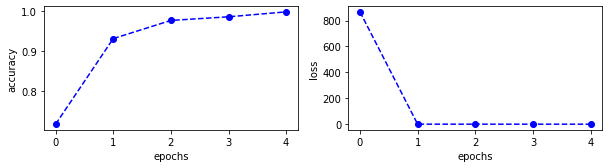

In [25]:
fig = plt.figure(figsize=(10,5))

# Plot accuracy
plt.subplot(221)
plt.plot(history.history['accuracy'], 'bo--', label='acc')
plt.ylabel('accuracy')
plt.xlabel('epochs') 

# Plot loss function
plt.subplot(222)
plt.plot(history.history['loss'], 'bo--', label='loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.show()

## Saving data for attacks

In [26]:
model.save('./target_model')
np.savetxt('y_val.txt', y_stealed, delimiter=',')
np.save('X_val.npy', X_stealed)

INFO:tensorflow:Assets written to: ./target_model\assets


INFO:tensorflow:Assets written to: ./target_model\assets


In [27]:
y_preds = model.predict(X_test, verbose=0)

In [28]:
def getCategory(data):
  y_prediction = []
  for item in data:
    max_value = max(item)
    max_index = list(item).index(max_value)
    y_prediction.append(max_index)
  return np.array(y_prediction).astype('int64')

y_prediction = getCategory(y_preds)
y_validation = getCategory(y_test)

## Metricas

In [29]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, f1_score, precision_score

In [30]:
print(classification_report(y_prediction, y_validation))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       0.95      0.76      0.84        25
           2       1.00      0.69      0.81        54
           3       1.00      0.33      0.50       139
           4       0.50      0.48      0.49        23
           5       1.00      1.00      1.00        20
           6       0.52      0.37      0.43        46
           7       0.40      0.22      0.29        36
           8       0.97      1.00      0.98        30
           9       0.20      1.00      0.33         4
          10       0.88      0.97      0.92        63
          11       1.00      1.00      1.00        74
          12       0.14      0.33      0.20        12
          13       0.00      0.00      0.00         0
          14       1.00      0.95      0.97        20
          15       0.79      0.90      0.84        21
          16       0.91      0.95      0.93        21
          17       0.00    

c:\Users\andre\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\andre\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\andre\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

In [31]:
confusion_matrix(y_validation, y_prediction)

array([[19,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 19,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,
         0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 37,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 46,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 11, 11,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 20,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  5,  0,  0,  0, 17,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  3,  0,  3,  4,  0,  1,  0],
       [ 0,  0,  4,  0,  0,  0,  2,  8,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  1,  0,  4,  1,  0,  0,  0],
       [ 0,  0,  0,  1,  0,  0,  0,  0, 30,  0,  0,  0,  0,  0, 

In [32]:
accuracy_score(y_validation, y_prediction)

0.6906377204884667